In [106]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

from sklearn.neighbors import KNeighborsRegressor

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import matthews_corrcoef

import pandas_profiling

In [4]:
item_categories = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv.zip')
sales_train = pd.read_csv('sales_train.csv.zip',  parse_dates=['date'], dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32','item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})
sample_submissions = pd.read_csv('sample_submission.csv.zip')
shops = pd.read_csv('shops.csv')
test = pd.read_csv('test.csv.zip')

In [5]:
item_categories.head(3)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2


In [6]:
items.head(3)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


In [7]:
sales_train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.0,1
1,2013-03-01,0,25,2552,899.0,1
2,2013-05-01,0,25,2552,899.0,-1


In [8]:
sample_submissions.head(3)

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5


In [9]:
shops.head(3)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2


In [10]:
test.head(3)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


## Here we merge all tables related with the train data into one table

In [11]:
# merge data into one table
train = sales_train.join(items, on = 'item_id', rsuffix='_')\
                    .join(item_categories, on = 'item_category_id', rsuffix = '_')\
                    .join(shops, on = 'shop_id', rsuffix = '_')\
                    .drop(['item_id_', 'shop_id_', 'item_category_id_', 'item_name'], axis=1)

train['item_cnt_day'] = np.abs(train['item_cnt_day'])
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_category_name,shop_name
0,2013-02-01,0,59,22154,999.000000,1,37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,2013-03-01,0,25,2552,899.000000,1,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2,2013-05-01,0,25,2552,899.000000,1,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,2013-06-01,0,25,2554,1709.050049,1,58,Музыка - Винил,"Москва ТРК ""Атриум"""
4,2013-01-15,0,25,2555,1099.000000,1,56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""


In [12]:
pandas_profiling.ProfileReport(train)

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Split dates for more detailed exploration

In [13]:
train['date'] = pd.to_datetime(train['date'], format='%m.%Y')
train['day'] = train['date'].dt.day
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year

train.head(4)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,item_category_name,shop_name,day,month,year
0,2013-02-01,0,59,22154,999.000000,1,37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",1,2,2013
1,2013-03-01,0,25,2552,899.000000,1,58,Музыка - Винил,"Москва ТРК ""Атриум""",1,3,2013
2,2013-05-01,0,25,2552,899.000000,1,58,Музыка - Винил,"Москва ТРК ""Атриум""",1,5,2013
3,2013-06-01,0,25,2554,1709.050049,1,58,Музыка - Винил,"Москва ТРК ""Атриум""",1,6,2013


## Check our data for missed values

In [14]:
train.isnull().sum()

date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_category_id      0
item_category_name    0
shop_name             0
day                   0
month                 0
year                  0
dtype: int64

## Group data by date, shop, item and category 

In [15]:
# group data by month
train_grouped_by_month = train[["month", "date_block_num", "shop_id", "item_id", "item_price", "item_cnt_day", "item_category_id", "year"]].groupby(['date_block_num',"shop_id", "item_id", "item_category_id"]).agg({"item_price":"mean","item_cnt_day":"sum","month":"min", "year":"min"}).reset_index()
train_grouped_by_month.rename(columns={"item_cnt_day": "item_cnt_month"}, inplace=True)

train_grouped_by_month.head(8)

,date_block_num,shop_id,item_id,item_category_id,item_price,item_cnt_month,month,year
0,0,0,32,40,221.0,6,1,2013
1,0,0,33,37,347.0,3,1,2013
2,0,0,35,40,247.0,1,1,2013
3,0,0,43,40,221.0,1,1,2013
4,0,0,51,57,128.5,2,1,2013
5,0,0,61,43,195.0,1,10,2013
6,0,0,75,40,76.0,1,1,2013
7,0,0,88,40,76.0,1,1,2013


## Count histograms

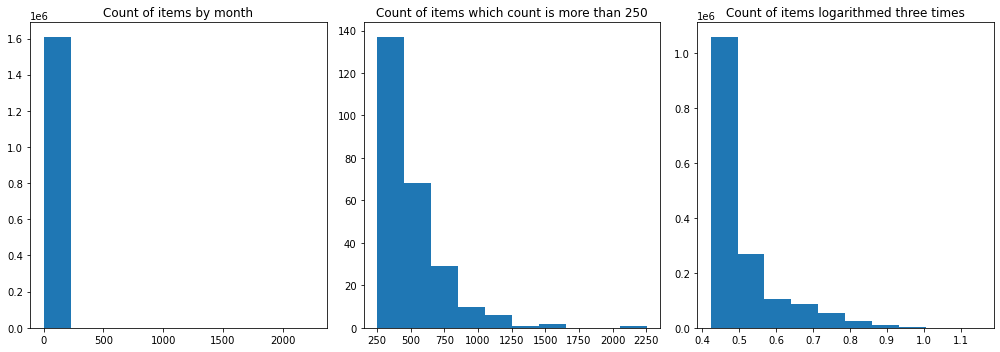

In [168]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 5))

#for ax in axes:
#    ax.plot(x, y, 'g')
#    ax.set_xlabel('x')
#    ax.set_ylabel('y')
#    ax.set_title('Заголовок')
    
axes[0].hist(train_grouped_by_month['item_cnt_month'])
axes[0].set_title('Count of items by month')

axes[1].hist(train_grouped_by_month.query('item_cnt_month > 250')['item_cnt_month'])
axes[1].set_title('Count of items which count is more than 250')

axes[2].hist(np.log(1 + np.log(1 + np.log(1 + train_grouped_by_month['item_cnt_month']))))
axes[2].set_title('Count of items logarithmed three times')

fig    
plt.tight_layout()

## Price histograms

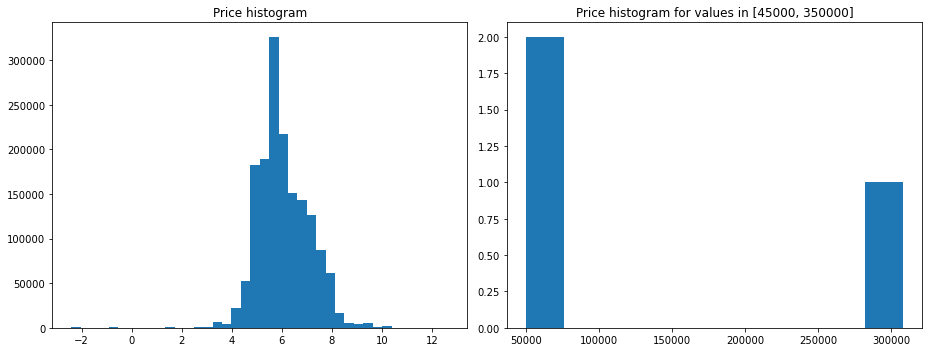

In [176]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))


axes[0].hist(np.log(train_grouped_by_month['item_price']), bins=40)
axes[0].set_title('Price histogram')

axes[1].hist(train_grouped_by_month.query('item_price > 45000 and item_price < 350000')['item_price'])
axes[1].set_title('Price histogram for values in [45000, 350000]')
fig    
plt.tight_layout()

## Function for obtaining regression line for Series

In [131]:
def get_regression_line(data: pd.Series) -> pd.Series:
    size = data.size
    x = pd.Series(range(size))
    
    mean_x = x.mean()
    sigma_x = x.std()
    
    mean_y = data.mean()
    sigma_y = data.std()
    
    corr_coef = 0

    #calculate correlation coefficient
    for i in range(size):
        corr_coef += (x[i] - mean_x) * (data[i] - mean_y)

    corr_coef /= (size * sigma_x * sigma_y)

    regression_line = pd.Series(mean_y + corr_coef * sigma_y / sigma_x * (k - mean_x) for k in range(size))
    
    return regression_line

## From this graphic we can obtain that sales have huge values on december

Text(0.5, 1.0, 'Count of sales by date block')

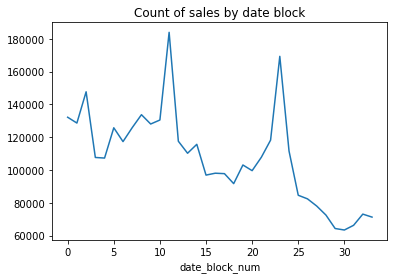

In [138]:
sales_by_date = train_grouped_by_month.groupby(['date_block_num'])['item_cnt_month'].sum()
sales_by_date.plot().set_title('Count of sales by date block')

## Construct regression line for count of sales

Text(0.5, 1.0, 'Regression line')

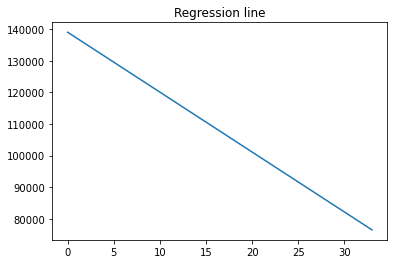

In [139]:
regression_line_count = get_regression_line(sales_by_date)
regression_line_count.plot().set_title('Regression line')

## Here we delete trend for count of sales

Text(0.5, 1.0, 'Count of sales without trend')

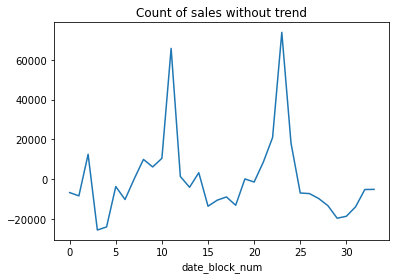

In [140]:
sales_without_trend = sales_by_date - regression_line
sales_without_trend.plot().set_title('Count of sales without trend')

Text(0.5, 1.0, 'Mean count of sales without trend by month')

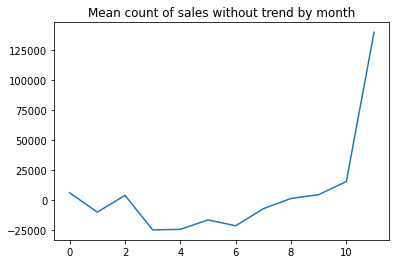

In [152]:
# group count of sales by month
sales_count_by_month = pd.Series([0 for i in range(12)])

for i in range(sales_without_trend.size):
    sales_count_by_month[i % 12] += sales_without_trend[i]
    
# divide by count of monthes to find mean value
for i in range(sales_price_by_month.size):
    sales_count_by_month[i] /= int((sales_without_trend.size - i) / 12)
    
sales_count_by_month.plot().set_title('Mean count of sales without trend by month')

## Total price by date

Text(0.5, 1.0, 'Total price for date')

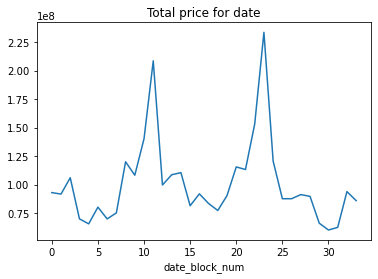

In [141]:
train_grouped_by_month['total_price'] = train_grouped_by_month['item_price'] * train_grouped_by_month['item_cnt_month']
sales_price_by_date = train_grouped_by_month.groupby(['date_block_num'])['total_price'].sum()
sales_price_by_date.plot().set_title('Total price for date')

## Construct regression line for total price by date

Text(0.5, 1.0, 'Regression line')

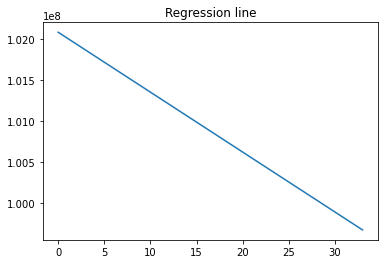

In [142]:
regression_line_total_price = get_regression_line(sales_price_by_date)
regression_line_total_price.plot().set_title('Regression line')

## Delete trend for total price of sales

Text(0.5, 1.0, 'Total price by date without trend')

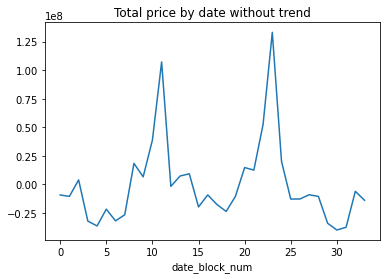

In [143]:
price_total_without_trend = sales_price_by_date - regression_line_total_price
price_total_without_trend.plot().set_title('Total price by date without trend')

Text(0.5, 1.0, 'Mean count of sales without trend by month')

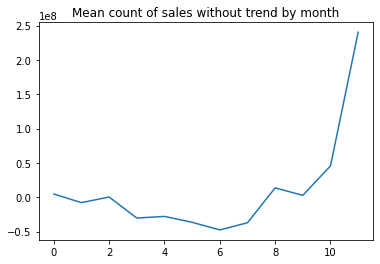

In [151]:
# group count of total price by month
sales_price_by_month = pd.Series([0 for i in range(12)])

for i in range(price_total_without_trend.size):
    sales_price_by_month[i % 12] += price_total_without_trend[i]
    
# divide by count of monthes to find mean value
for i in range(sales_price_by_month.size):
    sales_price_by_month[i] /= int((price_total_without_trend.size - i) / 12)
    
sales_price_by_month.plot().set_title('Mean count of sales without trend by month')

## We see that category №40 has more deifferent items, so we can split it into bins in future

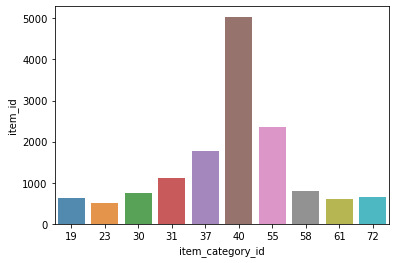

In [24]:
# number of items per category 
x=items.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
ax= sns.barplot(x=x.item_category_id, y=x.item_id, alpha=0.85)
plt.show()
# TODO: sort columns
# TODO: sort by count

## Obviously sales are decreaing

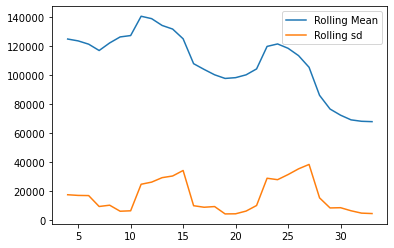

In [25]:
# rolling mean and standart deviation
plt.plot(sales_by_date.rolling(window=5,center=False).mean(),label='Rolling Mean');
plt.plot(sales_by_date.rolling(window=5,center=False).std(),label='Rolling sd');
plt.legend();

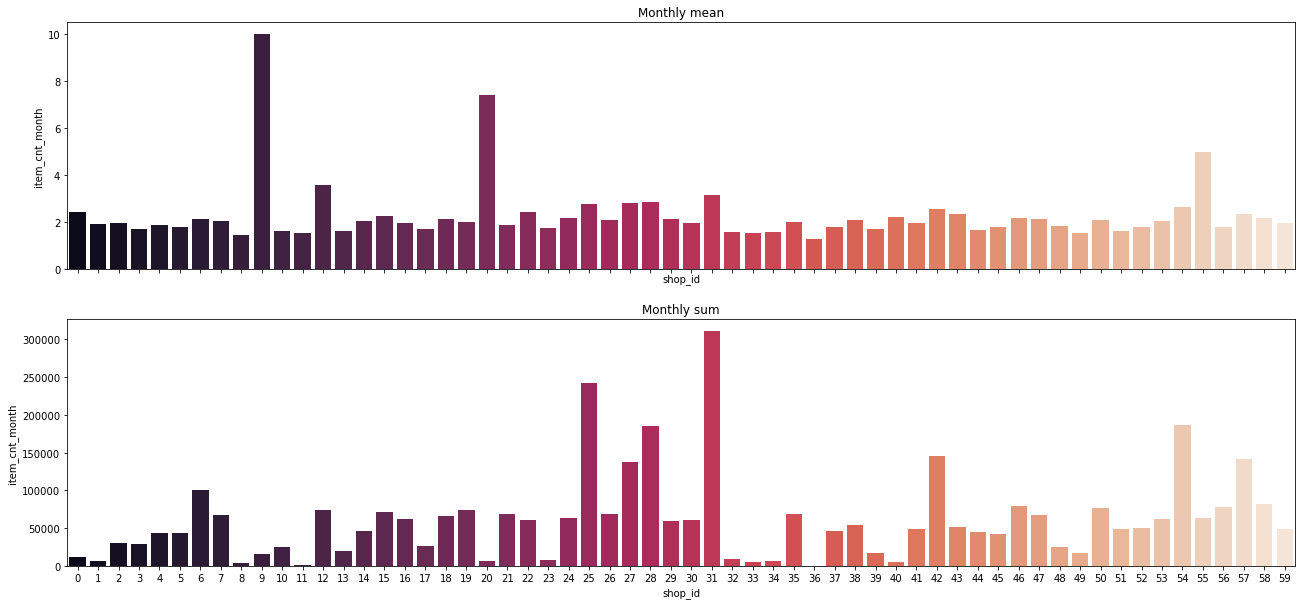

In [26]:
# check for sales statisticks depending on shop
shop_mean = train_grouped_by_month.groupby(['shop_id'], as_index=False)['item_cnt_month'].mean()
shop_sum = train_grouped_by_month.groupby(['shop_id'], as_index=False)['item_cnt_month'].sum()

f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt_month", data=shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt_month", data=shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

In [27]:
gp_shop_mean = train_grouped_by_month.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)

gp_item_mean = train_grouped_by_month.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)

gp_shop_item_mean = train_grouped_by_month.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)

gp_year_mean = train_grouped_by_month.groupby(['year']).agg({'item_cnt_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)

gp_month_mean = train_grouped_by_month.groupby(['month']).agg({'item_cnt_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)

train_grouped_by_month = pd.merge(train_grouped_by_month, gp_shop_mean, on=['shop_id'], how='left')
train_grouped_by_month = pd.merge(train_grouped_by_month, gp_item_mean, on=['item_id'], how='left')
train_grouped_by_month = pd.merge(train_grouped_by_month, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_grouped_by_month = pd.merge(train_grouped_by_month, gp_year_mean, on=['year'], how='left')
train_grouped_by_month = pd.merge(train_grouped_by_month, gp_month_mean, on=['month'], how='left')

train_set = train_grouped_by_month.query('date_block_num < 30').copy()
validation_set = train_grouped_by_month.query('date_block_num >= 30 and date_block_num < 33').copy()

X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)

X_val = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_val = validation_set['item_cnt_month'].astype(int)

test_upd = pd.merge(test, gp_shop_mean, on=['shop_id'], how='left')
test_upd = pd.merge(test_upd, gp_item_mean, on=['item_id'], how='left')
test_upd = pd.merge(test_upd, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
#test = pd.merge(test, gp_year_mean, on=['year'], how='left')
#test = pd.merge(test, gp_month_mean, on=['month'], how='left')

# TODO: validation function

X_train.head(3)

,shop_id,item_id,item_category_id,item_price,month,year,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
187136,2,31,37,699.0,12,2013,1.979811,2.861386,1.6,2.281527,1.490972
187137,2,464,49,299.0,4,2013,1.979811,2.417582,1.4,2.281527,2.253135
187138,2,482,73,3300.0,4,2013,1.979811,3.213443,1.4,2.281527,2.253135


In [28]:
X_train.rename(columns={"shop_mean_x": "shop_mean", "shop_item_mean_x": "shop_item_mean", \
                        "year_mean_x": "year_mean", "month_mean_x": "month_mean", "item_mean_x": "item_mean"}, inplace=True)

X_val.rename(columns={"shop_mean_x": "shop_mean", "shop_item_mean_x": "shop_item_mean", \
                        "year_mean_x": "year_mean", "month_mean_x": "month_mean", "item_mean_x": "item_mean"}, inplace=True)

test_upd.rename(columns={"shop_mean_y": "shop_mean", "item_mean_y": "item_mean", "shop_item_mean_y": "shop_item_mean", }, inplace=True)

knn_features = ['shop_mean', 'shop_item_mean', 'item_mean']

# delete this
X_train_sampled = X_train[:100000]
Y_train_sampled = Y_train[:100000]

knn_train = X_train_sampled[knn_features]
knn_val = X_val[knn_features]
knn_test = test_upd[knn_features]

knn_test.fillna(knn_test.mean(), inplace=True)
#knn_test.isna().sum()
knn_val.sample(10)

C:\Users\Yauheni_Minau\Anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,shop_mean,shop_item_mean,item_mean
795000,1.632631,4.750000,3.647303
370914,2.757016,1.000000,1.125000
912936,2.349816,1.000000,1.250000
920756,2.054797,2.800000,2.616080
831169,2.646592,1.375000,1.148649
1413923,1.788518,1.200000,1.920732
699740,2.016953,1.000000,1.311111
1055155,1.847349,1.200000,1.214689
1295814,2.646592,3.666667,1.696552
1152343,1.780820,1.222222,1.232759


In [29]:
knn_scaler = MinMaxScaler()
knn_scaler.fit(knn_train)
knn_train = knn_scaler.transform(knn_train)
knn_val = knn_scaler.transform(knn_val)
knn_test = knn_scaler.transform(knn_test)

In [30]:
knn_model = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
knn_model.fit(knn_train, Y_train_sampled)

KNeighborsRegressor(leaf_size=13, n_jobs=-1, n_neighbors=9)

In [31]:
knn_train_pred = knn_model.predict(knn_train)
knn_val_pred = knn_model.predict(knn_val)
knn_test_pred = knn_model.predict(knn_test)

In [32]:
np.sqrt(mean_squared_error(Y_train_sampled, knn_train_pred))

3.3021076322274556

In [33]:
np.sqrt(mean_squared_error(Y_val, knn_val_pred))

7.294143129290177

In [34]:
final_results = pd.DataFrame(knn_test_pred)
final_results.rename(columns={0:'item_cnt_month'}, inplace=True)
final_results.describe()

,item_cnt_month
count,214200.000000
mean,2.010286
std,2.332731
min,1.000000
25%,1.111111
50%,1.666667
75%,2.000000
max,114.555556


In [457]:
test['item_cnt_month'] = knn_test_pred
test = test.drop(['item_id', 'shop_id'], axis=1)
test.reset_index(drop=True)

,ID,item_cnt_month
0,0,1.111111
1,1,1.555556
2,2,1.888889
3,3,1.000000
4,4,1.555556
...,...,...
214195,214195,2.111111
214196,214196,1.555556
214197,214197,1.111111
214198,214198,1.777778


In [458]:
test.to_csv('result.csv')